In [ ]:
!pip install opendatasets

In [ ]:
# Import necessary libraries
import os
import opendatasets as od
import tensorflow as tf
from tensorflow.keras import models,applications,layers,losses,callbacks
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import seaborn as sn
import pathlib
import PIL
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import cv2
import numpy as np
from pathlib import Path
from google.colab.patches import cv2_imshow # Import cv2_imshow

In [ ]:
#Defining the dataset URL
dataset_url = "https://www.kaggle.com/datasets/alxmamaev/flowers-recognition?datasetId=8782&sortBy=voteCount"

#Defining the data directory
data_dir = './flowers-recognition/flowers'

#If there is no folder, download the dataset
if not os.path.isdir(data_dir):
    od.download(dataset_url)

#List classes
classes = os.listdir(data_dir)
print(classes)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ilaybozkurt
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
['dandelion', 'daisy', 'tulip', 'rose', 'sunflower']


Numpy array shape: (281, 500, 3)
Data type: uint8
Min/Max values: 10 255


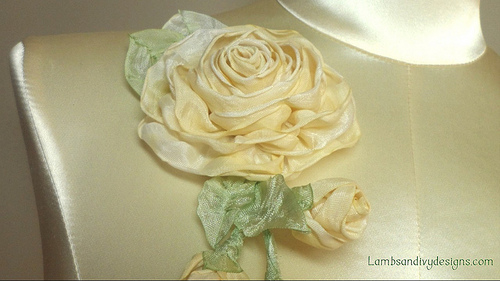

In [ ]:
#Define the data directory (custom structure for Kaggle)
data_dir = Path("./flowers-recognition/flowers")

#Collecting images of each flower type in the dictionary
flowers_img_dict = {
    'rose': list((data_dir/'rose').glob('*.jpg')),
    'daisy': list((data_dir/'daisy').glob('*.jpg')),
    'dandelion': list((data_dir/'dandelion').glob('*.jpg')),
    'sunflower': list((data_dir/'sunflower').glob('*.jpg')),
    'tulip': list((data_dir/'tulip').glob('*.jpg')),
}

#Assigning numerical labels to each flower type
flowers_lbl_dict = {
    'daisy': 0,
    'dandelion': 1,
    'rose': 2,
    'sunflower': 3,
    'tulip': 4
}


#Read and show the first rose image
if len(flowers_img_dict['rose']) > 0:
    img = cv2.imread(str(flowers_img_dict['rose'][0]))

    #Print image information
    print('Numpy array shape:', img.shape)
    print('Data type:', img.dtype)
    print('Min/Max values:', np.min(img), np.max(img))

    #Show image
    cv2_imshow(img)

else:
    print("No rose images found!")
    print("Current directory structure:", [p.name for p in data_dir.iterdir() if p.is_dir()])

In [ ]:
# Reading an image as numpy array
img=cv2.imread(str(flowers_img_dict['rose'][0]))
print('numpy array of an image:\n',img)


numpy array of an image:
 [[[ 77  98 106]
  [ 79 100 108]
  [ 81 100 107]
  ...
  [114 144 149]
  [114 144 149]
  [112 142 147]]

 [[ 82 101 109]
  [ 79  98 106]
  [ 79  98 105]
  ...
  [113 143 148]
  [113 143 148]
  [112 142 147]]

 [[ 85 103 114]
  [ 83 100 109]
  [ 81  98 107]
  ...
  [111 140 147]
  [111 140 147]
  [110 139 146]]

 ...

 [[ 60  80  97]
  [ 61  81  98]
  [ 58  78  96]
  ...
  [152 187 191]
  [151 188 192]
  [147 184 188]]

 [[ 74  89  98]
  [ 76  91 100]
  [ 80  94 106]
  ...
  [171 222 218]
  [175 226 222]
  [173 224 220]]

 [[ 43  52  56]
  [ 44  53  57]
  [ 45  54  58]
  ...
  [ 98 108 108]
  [100 110 110]
  [ 97 107 107]]]


In [ ]:
# check number of images in each type of flowers
for fldr_name,images in flowers_img_dict.items():
  print(fldr_name)
  print(len(images))

rose
784
daisy
764
dandelion
1052
sunflower
733
tulip
984


In [ ]:
#Creates the input (X) and label (Y) dataset from flower images and resizes each image to the same size (100x100 pixels)
#The model is brought to the required format for training.
X,Y=[],[]
for flowr_name,images in flowers_img_dict.items():
  for image in images:
    img=cv2.imread(str(image))
    resized_img=cv2.resize(img,(100,100))
    X.append(resized_img)
    Y.append(flowers_lbl_dict[flowr_name])

In [ ]:
#Converting lists to NumPy arrays
X=np.array(X)
Y=np.array(Y)
print('X:\n',X)
print('Y\n',Y)

X:
 [[[[ 79  98 105]
   [ 79  99 110]
   [ 82 102 113]
   ...
   [117 145 154]
   [115 145 150]
   [113 143 148]]

  [[ 78  97 108]
   [ 80  99 111]
   [ 81 101 112]
   ...
   [112 144 149]
   [114 143 152]
   [113 142 149]]

  [[ 76  96 107]
   [ 81 101 110]
   [ 81 101 113]
   ...
   [116 143 154]
   [114 143 152]
   [112 141 148]]

  ...

  [[ 63  82  95]
   [ 61  82  93]
   [ 66  84  97]
   ...
   [153 193 191]
   [152 191 191]
   [152 193 196]]

  [[ 68  84  95]
   [ 69  88  97]
   [ 70  85  95]
   ...
   [159 198 199]
   [156 197 199]
   [153 196 196]]

  [[ 77  90 101]
   [ 76  93 101]
   [ 79  90 103]
   ...
   [170 216 214]
   [166 216 211]
   [164 211 207]]]


 [[[184 206 210]
   [188 211 213]
   [184 210 210]
   ...
   [186 212 216]
   [184 210 214]
   [181 206 211]]

  [[186 209 211]
   [188 211 213]
   [186 211 213]
   ...
   [191 212 217]
   [190 212 217]
   [184 206 211]]

  [[188 212 212]
   [190 213 215]
   [189 214 218]
   ...
   [191 214 216]
   [192 215 217]
   [187

In [ ]:
#divides the image and label data you create into training (train) and test (test) sets.
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,random_state=0)
print('size of X_train:',X_train.shape) # check size of X_train
print('size of X_test:',X_test.shape) # check size of X_test
print('size of Y_train:',Y_train.shape) # check size of Y_train
print('size of Y_test:',Y_test.shape) # check size of Y_test

size of X_train: (3237, 100, 100, 3)
size of X_test: (1080, 100, 100, 3)
size of Y_train: (3237,)
size of Y_test: (1080,)


In [ ]:
# Normalize the pixel values to the range [0, 1]
X_train=X_train/255
X_test=X_test/255

In [ ]:
# Data augmentation to enhance model robustness
data_aug=tf.keras.Sequential([
    layers.RandomZoom(0.3),   #Zoom in or out of the image up to 30%
    layers.RandomFlip("horizontal_and_vertical"),   #Horizontal and vertical random flip
    layers.RandomRotation(0.2),   #Randomly rotate the image within ±20°
])

In [ ]:
#Allows defining the input type to be used in the model
input_shape = (100, 100)
IMG_SIZE = input_shape + (3,)

In [ ]:
def my_model_finetuned():
    # Loading VGG16 Model Trained with ImageNet
    base_model = tf.keras.applications.VGG16(input_shape=IMG_SIZE,
                                             include_top=False,
                                             weights='imagenet')

    # Freezing the First Convolution Block
    for layer in base_model.layers:
        if 'block1' in layer.name:
            layer.trainable = False


    # Printed to check which layers are frozen.
    print("Dondurma işleminden sonra eğitilebilir katmanlar:")
    for layer in base_model.layers:
        print(f"{layer.name}: {layer.trainable}")

    # Adding Custom Layers
    model = tf.keras.Sequential([
        data_aug,  # Veri artırma katmanı
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Aşırı öğrenmeyi engellemek için dropout
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')  # 5 sınıf için çıktı
    ])

    # Compiling the Model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model


In [ ]:
# Creating the Model
model_finetuned = my_model_finetuned()

# Defining TensorBoard Callback
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/logs_finetuned', histogram_freq=1)

# Training the Model
history_finetuned = model_finetuned.fit(
    X_train, Y_train,
    epochs=20,
    validation_split=0.2,
    callbacks=[tb_callback]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dondurma işleminden sonra eğitilebilir katmanlar:
input_layer: True
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: True
block2_conv2: True
block2_pool: True
block3_conv1: True
block3_conv2: True
block3_conv3: True
block3_pool: True
block4_conv1: True
block4_conv2: True
block4_conv3: True
block4_pool: True
block5_conv1: True
block5_conv2: True
block5_conv3: True
block5_pool: True
Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1054s 13s/step - accuracy: 0.2753 - loss: 1.5719 - val_accuracy: 0.5694 - val_loss: 1.0816
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1096s 13s/step - accuracy: 0.5414 - loss: 1.1821 - val_accuracy: 0.6312 - val_loss: 0.8512
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1044s 13s/step - accuracy: 0.6593 - loss: 0.9086 - val_accuracy: 0.7160 - val_loss: 0.7334
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1115s 13s/step - accuracy: 0.7105 - loss: 0.8097 - val_accuracy: 0.6775 - val_loss: 0.7785
Epoch 5/20
81/81 ━━━━━━━━

In [ ]:
# Function to evaluate the model
def eval(model, X, Y):
    model.evaluate(X, Y)

# Function for making predictions
def prediction(model, X, Y):
    Y_predict = model.predict(X)
    Y_pred = [np.argmax(i) for i in Y_predict]
    print('Predicted the first five labels:', Y_pred[:5])
    print('True labels of the first five elements:', Y[:5])
    return Y_pred

# Function to display classification report and confusion matrix
def report(truth, predictions):
    print(classification_report(truth, predictions))
    cm = tf.math.confusion_matrix(labels=truth, predictions=predictions)
    plt.figure(figsize=(10, 7))
    sn.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

# Function to plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Function to plot training and validation accuracy
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

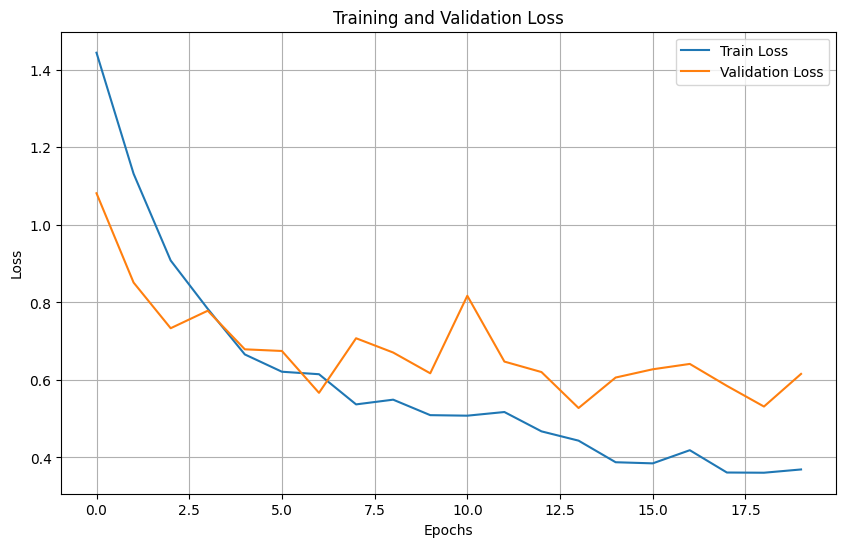

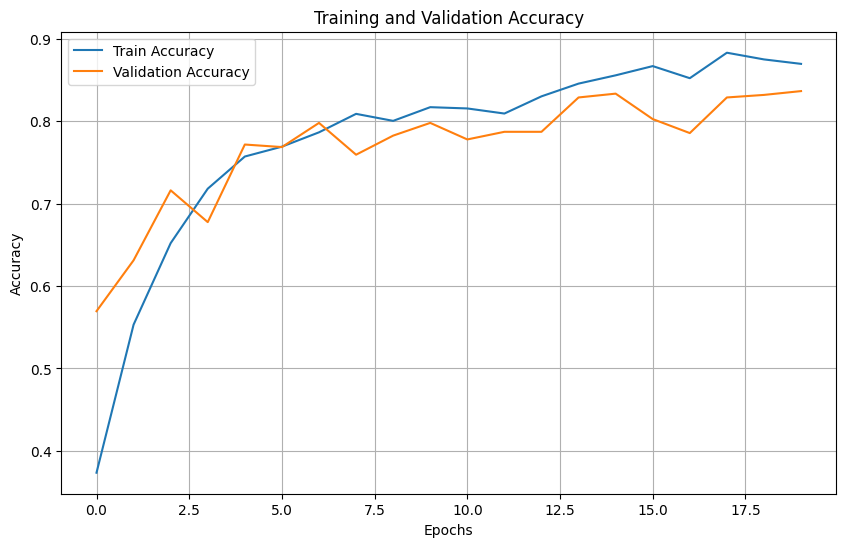

34/34 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.8428 - loss: 0.5067
34/34 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step
Predicted the first five labels: [np.int64(3), np.int64(4), np.int64(1), np.int64(4), np.int64(4)]
True labels of the first five elements: [3 0 1 2 4]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       184
           1       0.97      0.81      0.88       243
           2       0.78      0.81      0.80       214
           3       0.87      0.91      0.89       177
           4       0.80      0.85      0.83       262

    accuracy                           0.85      1080
   macro avg       0.85      0.85      0.85      1080
weighted avg       0.85      0.85      0.85      1080



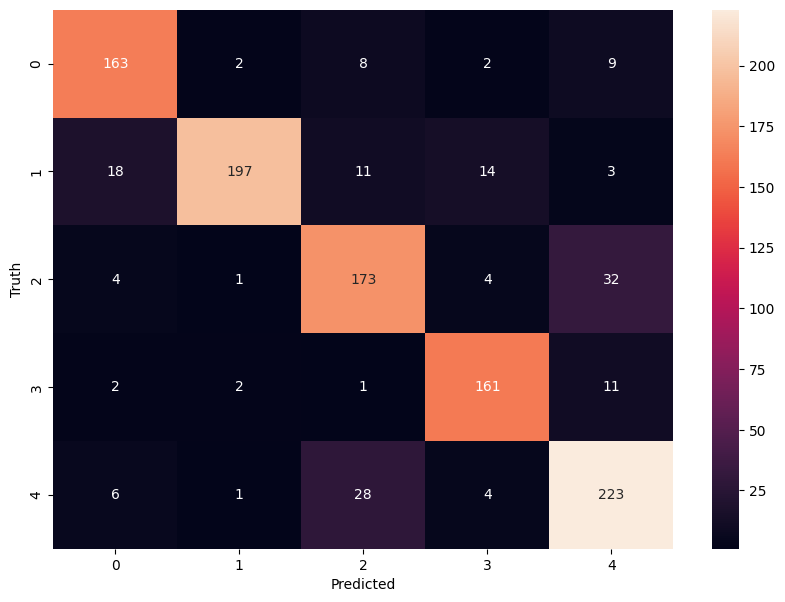

In [ ]:
# Visualization of the Educational Process
plot_loss(history_finetuned)
plot_accuracy(history_finetuned)

# Evaluation on Test Set
eval(model_finetuned, X_test, Y_test)

# Predictions and Classification Report
preds = prediction(model_finetuned, X_test, Y_test)
report(Y_test, preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


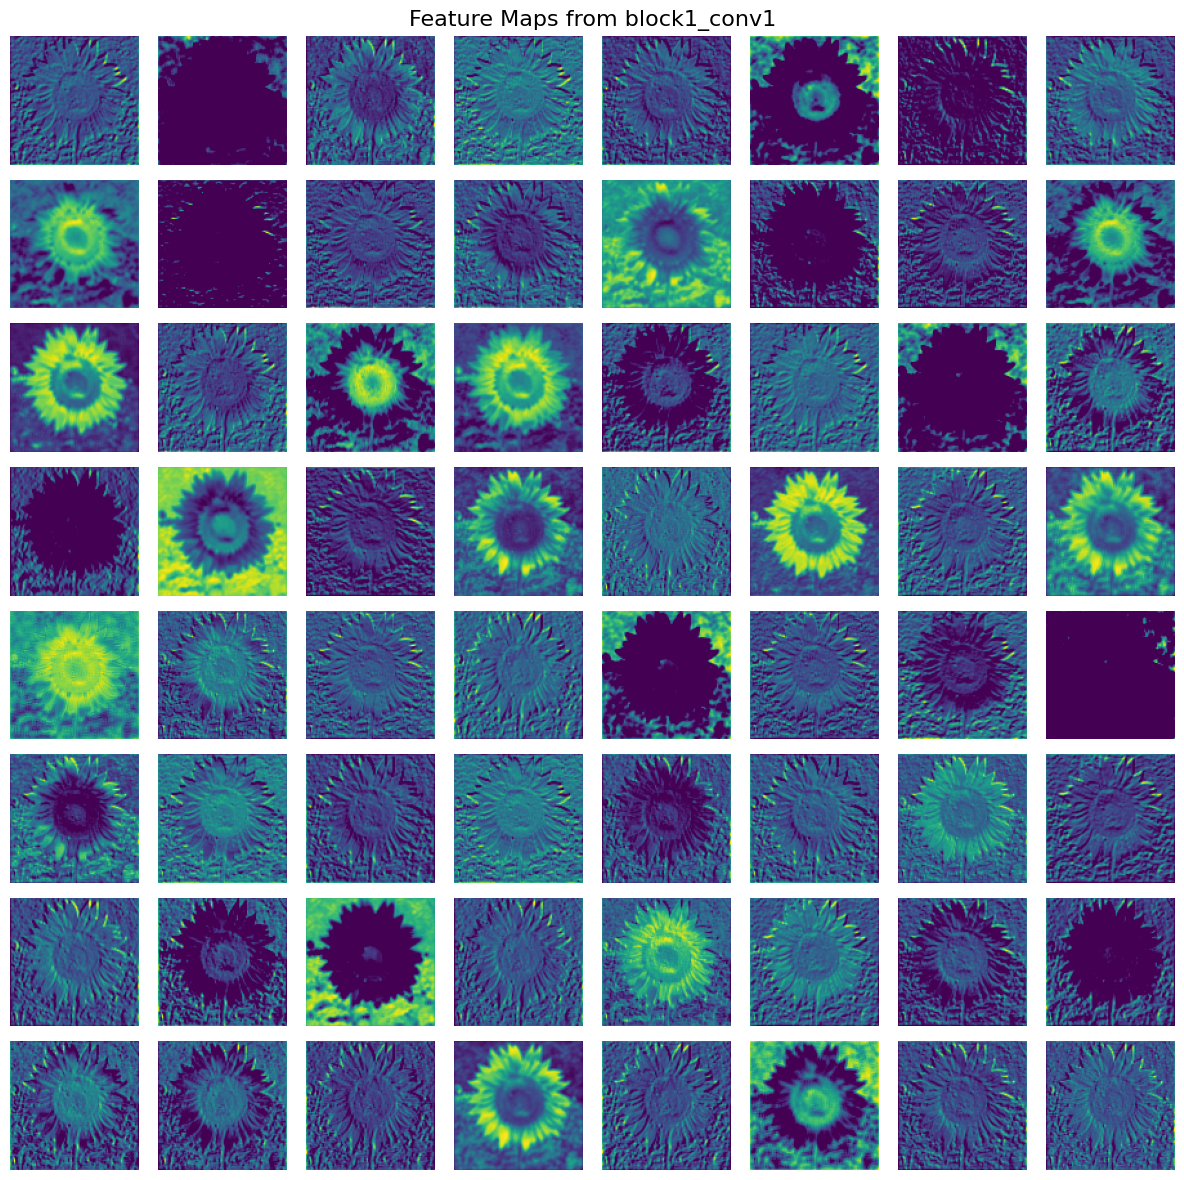

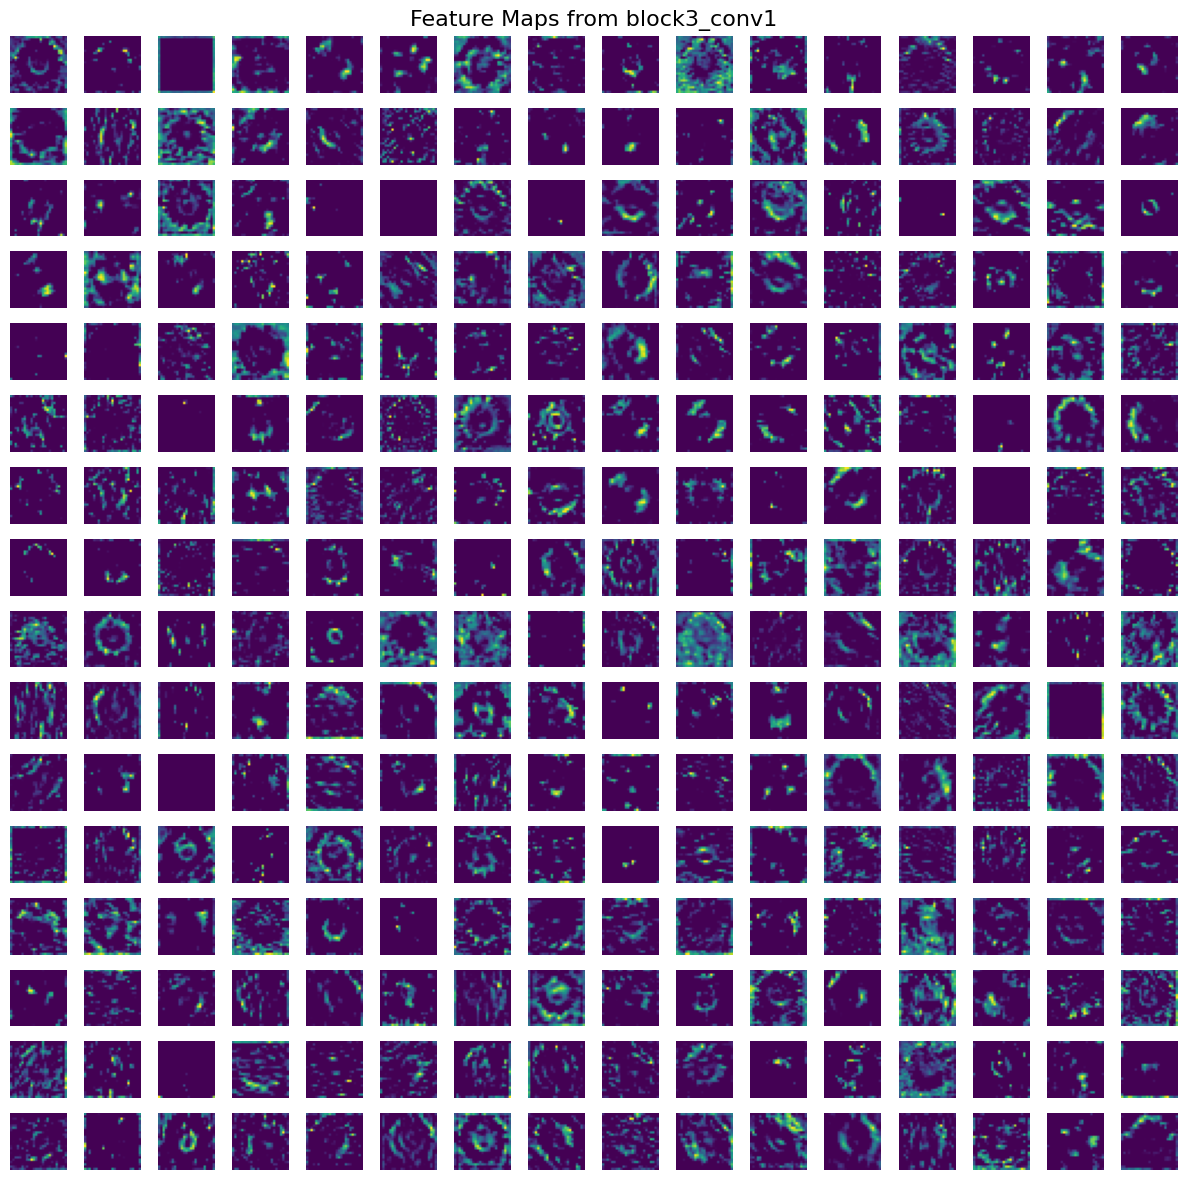

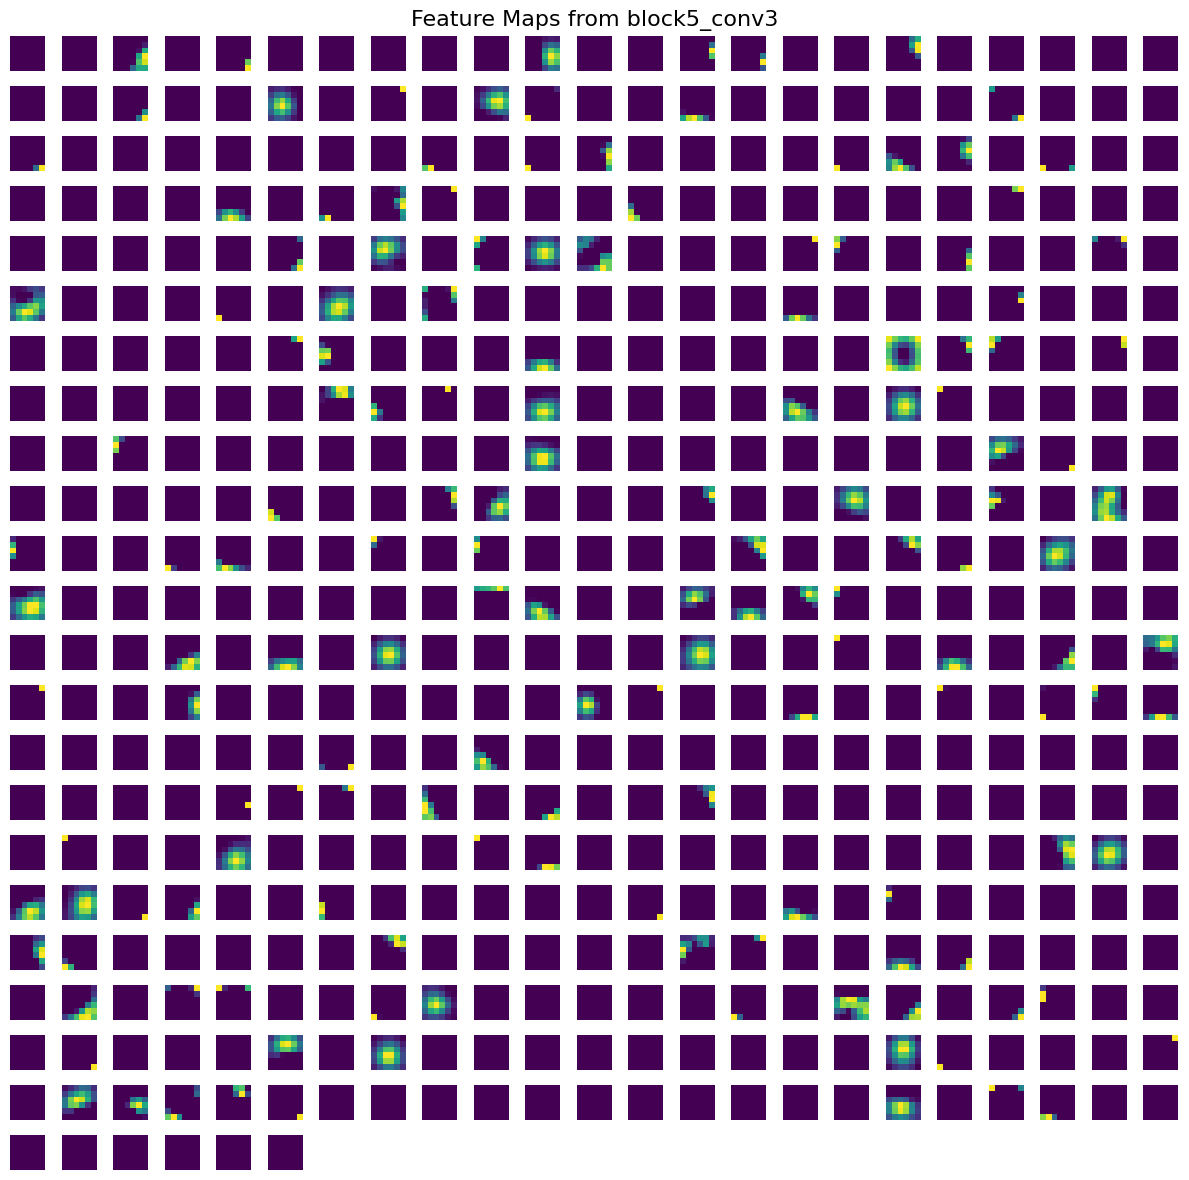

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

# Selecting Layers to Visualize
layer_names = ['block1_conv1', 'block3_conv1', 'block5_conv3']


# Getting the Base Model
base_model = model_finetuned.layers[1] # data_aug katmanından sonra base_model gelir

# Creating a Model to Create Feature Maps
feature_model = Model(inputs=base_model.input,
                      outputs=[base_model.get_layer(name).output for name in layer_names])

# Preparation of the Test Image
img = X_test[0]
img_input = np.expand_dims(img, axis=0)

# Visualization of Feature Maps
def visualize_feature_maps(model, img_input, layer_names):
    feature_maps = model.predict(img_input)

    for fmap, name in zip(feature_maps, layer_names):
        num_filters = fmap.shape[-1]
        size = fmap.shape[1]
        square = int(np.ceil(np.sqrt(num_filters)))

        fig, axes = plt.subplots(square, square, figsize=(12, 12))
        fig.suptitle(f'Feature Maps from {name}', fontsize=16)

        for i in range(square * square):
            ax = axes.flat[i]
            if i < num_filters:
                ax.imshow(fmap[0, :, :, i], cmap='viridis')
            ax.axis('off')

        plt.tight_layout()
        plt.show()


# Calling the Function
feature_map1 = visualize_feature_maps(feature_model, img_input, layer_names)
